In [10]:
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

db_path = r'C:\Users\marti\OneDrive\Desktop\noaa_seismic.db'  ##used r to import raw string 

In [19]:
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

db_path = r'C:\Users\marti\OneDrive\Desktop\noaa_seismic.db'
conn = sqlite3.connect(db_path)   

cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in database:", [t[0] for t in tables])


Tables in database: ['tsunamis_clean', 'earthquakes_clean', 'sqlite_sequence']


In [22]:
# Cell 1: Setup & Load Data from SQLite
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to  database
db_path = r"C:/Users/marti/OneDrive/Desktop/noaa_seismic.db"
conn = sqlite3.connect(db_path)

# Verify tables exist
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print("Tables:", cursor.fetchall())

# Load data into DataFrames
df_earthquakes = pd.read_sql_query("SELECT * FROM earthquakes_clean", conn)
df_tsunamis = pd.read_sql_query("SELECT * FROM tsunamis_clean", conn)

# Close connection
conn.close()

# Preview
print("\nEarthquakes shape:", df_earthquakes.shape)
print("Tsunamis shape:", df_tsunamis.shape)

Tables: [('tsunamis_clean',), ('earthquakes_clean',), ('sqlite_sequence',)]

Earthquakes shape: (4042, 38)
Tsunamis shape: (1607, 45)


In [24]:
# Cell 2: Earthquake Magnitude Analysis
# Clean magnitude column
df_earthquakes['Mag'] = pd.to_numeric(df_earthquakes['Mag'], errors='coerce')

# Drop rows without magnitude
df_eq_clean = df_earthquakes.dropna(subset=['Mag'])

# Basic stats
print("Magnitude Statistics:")
print(df_eq_clean['Mag'].describe())

# Distribution by category
bins = [0, 5, 6, 7, 8, 10]
labels = ['Minor (<5)', 'Moderate (5-6)', 'Strong (6-7)', 'Major (7-8)', 'Great (8+)']
df_eq_clean['Mag_Category'] = pd.cut(df_eq_clean['Mag'], bins=bins, labels=labels)

print("\nEvents by Magnitude Category:")
print(df_eq_clean['Mag_Category'].value_counts().sort_index())


Magnitude Statistics:
count    3751.000000
mean        6.345508
std         1.042886
min         1.600000
25%         5.600000
50%         6.400000
75%         7.200000
max         9.500000
Name: Mag, dtype: float64

Events by Magnitude Category:
Mag_Category
Minor (<5)         444
Moderate (5-6)    1050
Strong (6-7)      1191
Major (7-8)        959
Great (8+)         107
Name: count, dtype: int64


C:\Users\marti\AppData\Local\Temp\ipykernel_27704\3129462204.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eq_clean['Mag_Category'] = pd.cut(df_eq_clean['Mag'], bins=bins, labels=labels)


In [29]:
# Cell 3: Tsunami Analysis (CORRECT COLUMN NAMES)
WAVE_COL = 'Max_Water_Height_m'
MAG_COL = 'Earthquake_Mag'

df_tsunamis[WAVE_COL] = pd.to_numeric(df_tsunamis[WAVE_COL], errors='coerce')
df_tsunamis[MAG_COL] = pd.to_numeric(df_tsunamis[MAG_COL], errors='coerce')

# Clean dataset
df_ts_clean = df_tsunamis.dropna(subset=[WAVE_COL, MAG_COL])

print("Tsunami records with complete data:", len(df_ts_clean))
print(df_ts_clean[WAVE_COL].describe())



Tsunami records with complete data: 833
count    833.000000
mean       2.972713
std       18.895058
min        0.000000
25%        0.120000
50%        0.440000
75%        2.000000
max      524.600000
Name: Max_Water_Height_m, dtype: float64


In [31]:
# Cell 4: Correlation Analysis (NO WARNINGS)
WAVE_COL = 'Max_Water_Height_m'
MAG_COL = 'Earthquake_Mag'

correlation = df_ts_clean[MAG_COL].corr(df_ts_clean[WAVE_COL])
print(f"Pearson Correlation (r): {correlation:.2f}")

bins = [0, 6, 7, 8, 10]
labels = ['<6.0', '6.0-7.0', '7.0-8.0', '8.0+']

# Use .loc to avoid SettingWithCopyWarning
df_ts_clean = df_ts_clean.copy()
df_ts_clean.loc[:, 'Mag_Bin'] = pd.cut(df_ts_clean[MAG_COL], bins=bins, labels=labels)

print("\nAverage Wave Height by Magnitude:")
print(df_ts_clean.groupby('Mag_Bin', observed=True)[WAVE_COL].mean())



Pearson Correlation (r): 0.13

Average Wave Height by Magnitude:
Mag_Bin
<6.0       1.003485
6.0-7.0    1.234469
7.0-8.0    3.573718
8.0+       9.581364
Name: Max_Water_Height_m, dtype: float64


In [34]:

# EARTHQUAKE QUESTIONS:
# 1. Which regions have the highest average magnitude?
print("=== AVG MAGNITUDE BY LOCATION ===")
by_location = df_earthquakes.groupby('Location_Name')['Mag'].agg(['mean', 'count', 'max'])
by_location = by_location[by_location['count'] >= 5].sort_values('mean', ascending=False)
print(by_location.head(10).round(2))

# 2. What percentage of earthquakes are magnitude 7+?
mag7_plus = (df_earthquakes['Mag'] >= 7).sum()
total = len(df_earthquakes)
print(f"\nMagnitude 7+ earthquakes: {mag7_plus} ({mag7_plus/total*100:.1f}%)")

# 3. What's the deadliest year on record?
print("\n=== DEADLIEST YEARS ===")
# Convert Deaths to numeric first
df_earthquakes['Deaths'] = pd.to_numeric(df_earthquakes['Deaths'], errors='coerce')
by_year = df_earthquakes.groupby('Year')['Deaths'].sum().sort_values(ascending=False)
print(by_year.head(10))

# TSUNAMI QUESTIONS:
# 4. What causes the most tsunamis?
print("\n=== TSUNAMI CAUSES ===")
if 'Cause_Code' in df_tsunamis.columns:
    print(df_tsunamis['Cause_Code'].value_counts())
else:
    print("Cause column not found in dataset")

# 5. What's the tallest wave on record?
max_idx = df_tsunamis['Max_Water_Height_m'].idxmax()
max_wave = df_tsunamis.loc[max_idx]
print(f"\nTallest wave: {max_wave['Max_Water_Height_m']}m")
print(f"Location: {max_wave['Location_Name']}")
print(f"Year: {max_wave['Year']}")

# 6. Tsunamis by region
print("\n=== TSUNAMIS BY REGION ===")
print(df_tsunamis['Location_Name'].value_counts().head(15))


=== AVG MAGNITUDE BY LOCATION ===
                                     mean  count  max
Location_Name                                        
RUSSIA:  KAMCHATKA PENINSULA         8.02      6  9.0
AUSTRALIA:  MACQUARIE ISLAND         7.82      5  8.1
MONGOLIA                             7.80      6  8.4
ALASKA                               7.78      9  9.2
INDONESIA:  NEW GUINEA:  IRIAN JAYA  7.73      7  8.1
SAMOA ISLANDS                        7.72      5  8.3
SOUTH SANDWICH ISLANDS               7.71      7  8.1
INDONESIA:  BANDA SEA                7.67      9  8.3
PAPUA NEW GUINEA:  NEW IRELAND       7.66      5  7.8
PAPUA NEW GUINEA:  NEW BRITAIN       7.63      9  8.0

Magnitude 7+ earthquakes: 1215 (30.1%)

=== DEADLIEST YEARS ===
Year
2010    319480.0
1976    279770.0
1920    238155.0
1948    116141.0
1923    113189.0
2008     88132.0
1970     83914.0
2005     78195.0
1908     78000.0
1935     67441.0
Name: Deaths, dtype: float64

=== TSUNAMI CAUSES ===
Cause_Code
1             

<module 'matplotlib.pyplot' from 'C:\\Users\\marti\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

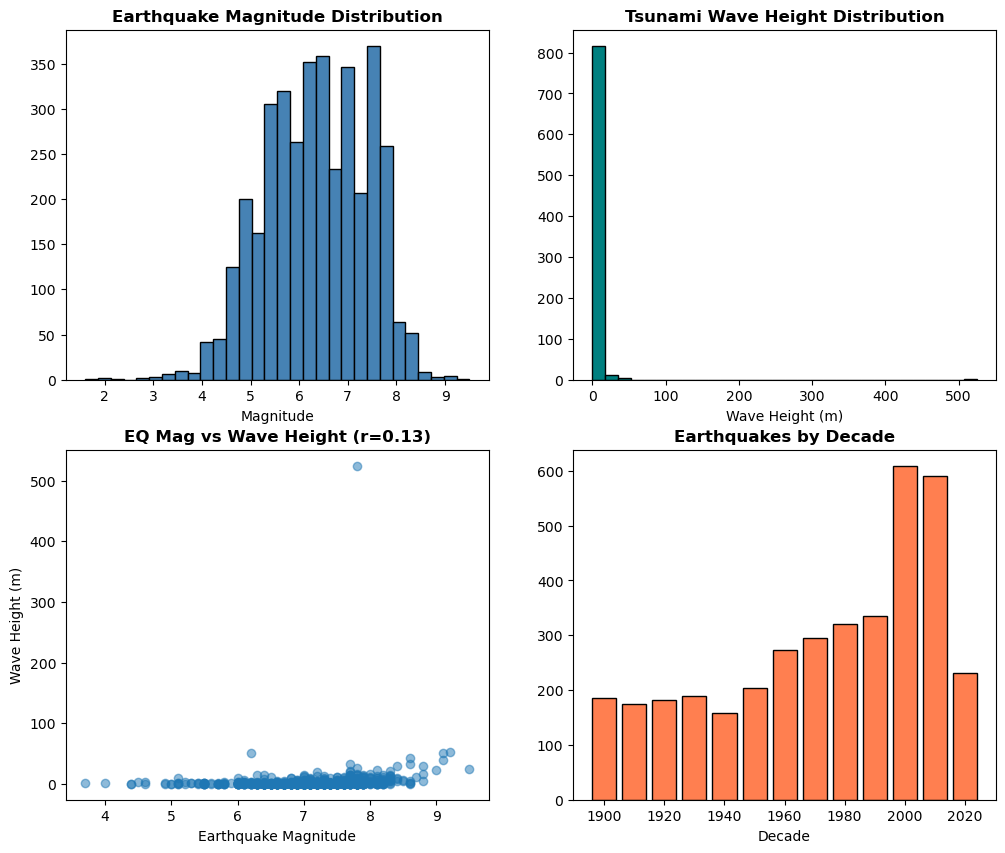

In [3]:
# Cell 5: Visualization 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

# Connect & load data
conn = sqlite3.connect(r'C:\Users\marti\OneDrive\Desktop\noaa_seismic.db')
df_earthquakes = pd.read_sql_query("SELECT * FROM earthquakes_clean", conn)
df_tsunamis = pd.read_sql_query("SELECT * FROM tsunamis_clean", conn)
conn.close()

# Clean data for plotting
df_earthquakes['Mag'] = pd.to_numeric(df_earthquakes['Mag'], errors='coerce')
df_tsunamis['Max_Water_Height_m'] = pd.to_numeric(df_tsunamis['Max_Water_Height_m'], errors='coerce')
df_tsunamis['Earthquake_Mag'] = pd.to_numeric(df_tsunamis['Earthquake_Mag'], errors='coerce')

df_eq_clean = df_earthquakes.dropna(subset=['Mag']).copy()
df_ts_clean = df_tsunamis.dropna(subset=['Earthquake_Mag', 'Max_Water_Height_m']).copy()


# Create 4-panel dashboard
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0,0].hist(df_eq_clean['Mag'], bins=30, edgecolor='black', color='steelblue')
axes[0,0].set_title('Earthquake Magnitude Distribution', fontweight='bold')
axes[0,0].set_xlabel('Magnitude')

axes[0,1].hist(df_ts_clean['Max_Water_Height_m'], bins=30, edgecolor='black', color='teal')
axes[0,1].set_title('Tsunami Wave Height Distribution', fontweight='bold')
axes[0,1].set_xlabel('Wave Height (m)')

corr = df_ts_clean['Earthquake_Mag'].corr(df_ts_clean['Max_Water_Height_m'])
axes[1,0].scatter(df_ts_clean['Earthquake_Mag'], df_ts_clean['Max_Water_Height_m'], alpha=0.5)
axes[1,0].set_title(f'EQ Mag vs Wave Height (r={corr:.2f})', fontweight='bold')
axes[1,0].set_xlabel('Earthquake Magnitude')
axes[1,0].set_ylabel('Wave Height (m)')

df_eq_clean['Year'] = pd.to_numeric(df_eq_clean['Year'], errors='coerce')
df_eq_clean['Decade'] = (df_eq_clean['Year'] // 10) * 10
decade_counts = df_eq_clean.groupby('Decade').size()
axes[1,1].bar(decade_counts.index, decade_counts.values, width=8, color='coral', edgecolor='black')
axes[1,1].set_title('Earthquakes by Decade', fontweight='bold')
axes[1,1].set_xlabel('Decade')

plt



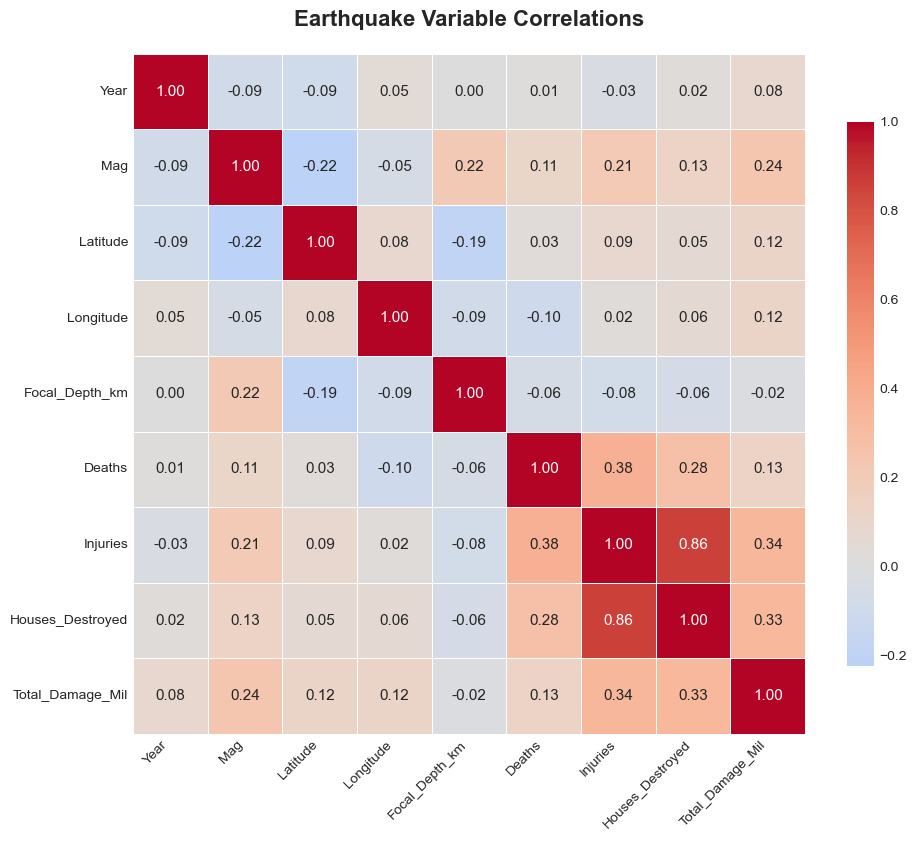

In [16]:
# Cell: Correlation Heatmap 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Connect & load data
conn = sqlite3.connect(r'C:\Users\marti\OneDrive\Desktop\noaa_seismic.db')
earthquakes = pd.read_sql_query("SELECT * FROM earthquakes_clean", conn)
conn.close()

# Columns to use
numeric_cols = ['Year', 'Mag', 'Latitude', 'Longitude', 'Focal_Depth_km', 
                'Deaths', 'Injuries', 'Houses_Destroyed', 'Total_Damage_Mil']

existing_cols = [c for c in numeric_cols if c in earthquakes.columns]

for col in existing_cols:
    earthquakes[col] = pd.to_numeric(earthquakes[col], errors='coerce')

corr_data = earthquakes[existing_cols].dropna()
correlation_matrix = corr_data.corr()

# Larger figure + bottom margin for labels
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=0.5, ax=ax, annot_kws={'size': 11},
            cbar_kws={'shrink': 0.8})

ax.set_title('Earthquake Variable Correlations', fontweight='bold', fontsize=16, pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

# Add more bottom margin
plt.subplots_adjust(bottom=0.2, left=0.2)

plt.savefig(r'C:\Users\marti\OneDrive\Desktop\correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()



In [17]:
# Cell: Interactive Map 
import pandas as pd
import sqlite3
import folium
from folium.plugins import MarkerCluster

# Connect & load data
conn = sqlite3.connect(r'C:\Users\marti\OneDrive\Desktop\noaa_seismic.db')
earthquakes = pd.read_sql_query("SELECT * FROM earthquakes_clean", conn)
tsunamis = pd.read_sql_query("SELECT * FROM tsunamis_clean", conn)
conn.close()

# Convert to numeric
earthquakes['Latitude'] = pd.to_numeric(earthquakes['Latitude'], errors='coerce')
earthquakes['Longitude'] = pd.to_numeric(earthquakes['Longitude'], errors='coerce')
earthquakes['Mag'] = pd.to_numeric(earthquakes['Mag'], errors='coerce')
earthquakes['Year'] = pd.to_numeric(earthquakes['Year'], errors='coerce')

# Filter valid coordinates and major earthquakes (Mag 7+)
eq_map = earthquakes.dropna(subset=['Latitude', 'Longitude', 'Mag']).copy()
eq_major = eq_map[eq_map['Mag'] >= 7]

print(f"Mapping {len(eq_major)} major earthquakes (M7.0+)")

# Create map centered on Pacific
m = folium.Map(location=[20, 150], zoom_start=2, tiles='cartodbpositron')

# Add marker cluster
marker_cluster = MarkerCluster().add_to(m)

# Add earthquake markers
for idx, row in eq_major.iterrows():
    popup_text = f"""
    <b>Magnitude:</b> {row['Mag']}<br>
    <b>Location:</b> {row['Location_Name']}<br>
    <b>Year:</b> {int(row['Year']) if pd.notna(row['Year']) else 'Unknown'}
    """
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Mag'] * 2,
        color='red',
        fill=True,
        fillColor='red',
        fillOpacity=0.6,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(marker_cluster)

# Save map
m.save(r'C:\Users\marti\OneDrive\Desktop\earthquake_map.html')





Mapping 1215 major earthquakes (M7.0+)


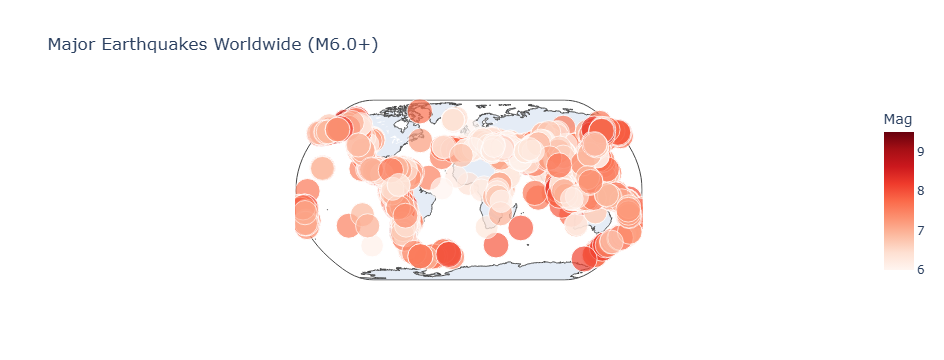

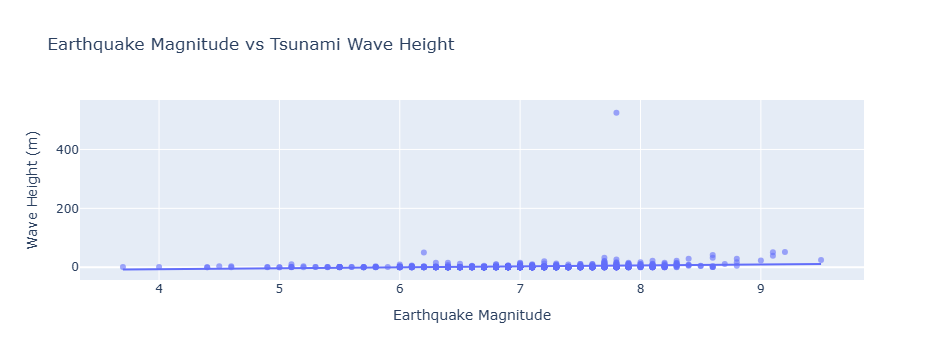

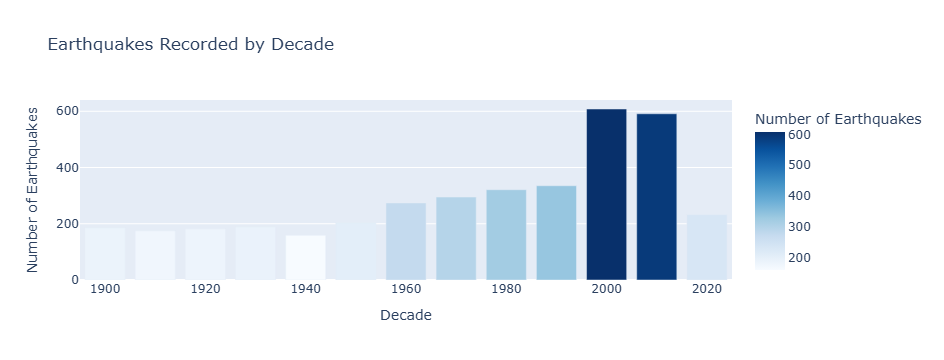

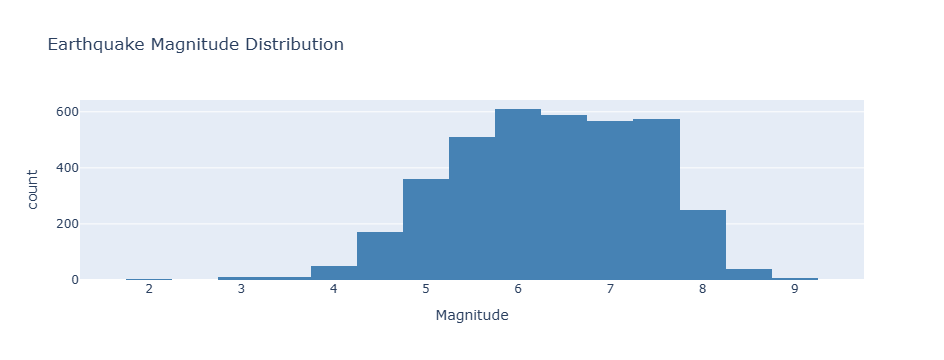

In [18]:
# Cell: Part D - Interactive Plotly Charts 
import pandas as pd
import numpy as np
import sqlite3
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Connect & load data
conn = sqlite3.connect(r'C:\Users\marti\OneDrive\Desktop\noaa_seismic.db')
earthquakes = pd.read_sql_query("SELECT * FROM earthquakes_clean", conn)
tsunamis = pd.read_sql_query("SELECT * FROM tsunamis_clean", conn)
conn.close()

# Convert to numeric
earthquakes['Year'] = pd.to_numeric(earthquakes['Year'], errors='coerce')
earthquakes['Mag'] = pd.to_numeric(earthquakes['Mag'], errors='coerce')
earthquakes['Deaths'] = pd.to_numeric(earthquakes['Deaths'], errors='coerce').fillna(0)
earthquakes['Latitude'] = pd.to_numeric(earthquakes['Latitude'], errors='coerce')
earthquakes['Longitude'] = pd.to_numeric(earthquakes['Longitude'], errors='coerce')

tsunamis['Max_Water_Height_m'] = pd.to_numeric(tsunamis['Max_Water_Height_m'], errors='coerce')
tsunamis['Earthquake_Mag'] = pd.to_numeric(tsunamis['Earthquake_Mag'], errors='coerce')

# Clean data
eq_clean = earthquakes.dropna(subset=['Mag', 'Latitude', 'Longitude']).copy()
ts_clean = tsunamis.dropna(subset=['Earthquake_Mag', 'Max_Water_Height_m']).copy()

# ============================================
# CHART 1: Interactive Scatter Map
# ============================================
fig1 = px.scatter_geo(
    eq_clean[eq_clean['Mag'] >= 6],
    lat='Latitude',
    lon='Longitude',
    size='Mag',
    color='Mag',
    hover_name='Location_Name',
    hover_data=['Year', 'Deaths'],
    title='Major Earthquakes Worldwide (M6.0+)',
    color_continuous_scale='Reds',
    projection='natural earth'
)
fig1.write_html(r'C:\Users\marti\OneDrive\Desktop\earthquake_scatter_map.html')
fig1.show()

# ============================================
# CHART 2: Magnitude vs Wave Height Scatter
# ============================================
fig2 = px.scatter(
    ts_clean,
    x='Earthquake_Mag',
    y='Max_Water_Height_m',
    trendline='ols',
    title='Earthquake Magnitude vs Tsunami Wave Height',
    labels={'Earthquake_Mag': 'Earthquake Magnitude', 'Max_Water_Height_m': 'Wave Height (m)'},
    opacity=0.6
)
fig2.write_html(r'C:\Users\marti\OneDrive\Desktop\correlation_scatter.html')
fig2.show()

# ============================================
# CHART 3: Earthquakes by Decade (Bar Chart)
# ============================================
eq_clean['Decade'] = (eq_clean['Year'] // 10) * 10
decade_counts = eq_clean.groupby('Decade').size().reset_index(name='Count')

fig3 = px.bar(
    decade_counts,
    x='Decade',
    y='Count',
    title='Earthquakes Recorded by Decade',
    labels={'Decade': 'Decade', 'Count': 'Number of Earthquakes'},
    color='Count',
    color_continuous_scale='Blues'
)
fig3.write_html(r'C:\Users\marti\OneDrive\Desktop\decade_bar_chart.html')
fig3.show()

# ============================================
# CHART 4: Magnitude Distribution Histogram
# ============================================
fig4 = px.histogram(
    eq_clean,
    x='Mag',
    nbins=30,
    title='Earthquake Magnitude Distribution',
    labels={'Mag': 'Magnitude', 'count': 'Frequency'},
    color_discrete_sequence=['steelblue']
)
fig4.write_html(r'C:\Users\marti\OneDrive\Desktop\magnitude_histogram.html')
fig4.show()


